
# Worked Example: Magpie Features + Random Forest (Materials Project)

This notebook demonstrates how to:
1. **Query** a small dataset from the Materials Project (MP) API
2. **Featurize** compositions using **Magpie** features via `matminer`
3. **Train** a simple **Random Forest** regressor and evaluate it

> **API key:** Set the environment variable `MP_API_KEY` before running (e.g., in a shell: `export MP_API_KEY='your_key'`).  
> **Target:** We'll predict **formation energy per atom** as a regression example.


In [1]:

# If running on a fresh environment, uncomment the following:
%pip install -q mp-api pymatgen matminer scikit-learn pandas numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━

---

## 🔑 Setting Up Your Environment and Materials Project Access

Before we can query data from the **Materials Project (MP)**, we need to import a few key Python libraries and configure access credentials.

**What this cell does:**
1. Imports standard tools like `pandas`, `numpy`, and key machine learning modules from `scikit-learn`.  
2. Attempts to import the modern **MP API client** (`mp_api.client.MPRester`) and sets a fallback to the older **`pymatgen`** interface in case the new client isn’t installed.  
3. Imports the `matminer` featurizer (`ElementProperty`) and `pymatgen.Composition` for later use when generating Magpie features.  
4. Sets a random seed for reproducibility of results.  
5. Loads your **Materials Project API key**, which authenticates your access to the database.

⚠️ **Important:**  
You must provide your personal **MP API key** before running this cell.  
There are two easy ways to do this:

- **Option 1:** For quick testing and in this case we define the key in the notebook:
```python
api_key = "your-key-here"
```

- **Option 2:** Better if you use these notebooks lots on local machines, store it as an environment variable in your terminal before starting Jupyter:  
```bash
  export MP_API_KEY="your-key-here"
  ```


In [2]:

import os
import pandas as pd
import numpy as np

# MP client (new API)
try:
    from mp_api.client import MPRester  # modern client
    MP_CLIENT = "mp-api"
except Exception:
    MP_CLIENT = None

# Legacy client (fallback)
try:
    from pymatgen.ext.matproj import MPRester as LegacyMPRester  # legacy client
    LEGACY_CLIENT = "pymatgen"
except Exception:
    LEGACY_CLIENT = None

from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

api_key = "XXXXXXXXXX"
if api_key is None:
    raise RuntimeError("Please set MP_API_KEY in your environment before running this notebook.")
print(f"Using API key from environment (length={len(api_key)}).")


Using API key from environment (length=32).


---
## Query a small dataset from Materials Project

We'll pull a modest set (≈100–300 entries) across simple binary and ternary chemical systems,
requesting a few fields including `formula_pretty` and `formation_energy_per_atom`.
With the modern **mp-api**, we query the **Thermo** endpoint. If unavailable, we fall back to legacy `pymatgen`.

This function queries a small set of materials directly from the **Materials Project (MP)** database using the `mp-api` or, if necessary, the legacy `pymatgen` client.

**Step-by-step explanation:**

1. **Define what data we need**  
   We request each material’s ID (`material_id`), its chemical formula (`formula_pretty`), and its **formation energy per atom** — a key thermodynamic stability descriptor.

2. **Choose a few chemical systems**  
   To keep the dataset small and diverse, we sample a handful of binary and ternary systems such as `Li–O`, `Na–Cl`, and `Fe–O`.  
   These give a mix of oxides, halides, and mixed-metal compounds for the example.

3. **Query the MP database**  
   - If the modern **`mp-api`** client is available, we use the **Thermo endpoint** (`mpr.thermo.search`) to fetch the desired fields.  
   - If not, we fall back to the **legacy** `pymatgen` interface.  
   The code ensures the correct field names are used for each API version.

4. **Extract relevant data**  
   Each material record provides the formula, formation energy, and ID.  
   Invalid or incomplete entries are skipped to avoid missing values.

5. **Combine results into a DataFrame**  
   All entries are collected into a single `pandas` DataFrame, duplicates removed, and rows with missing values dropped.

The resulting dataset (`df_raw`) is a compact and clean sample of real Materials Project data, ready to be **featurized** with Magpie descriptors in the next step.

---

**NB** It will not be necessary for you to query the MP database in your coursework, but this code may be useful to you in future.



In [3]:

def fetch_mp_dataset(n_limit=200):
    """
    Fetch a small set of materials from Materials Project with the fields we need.
    Returns a pandas DataFrame with columns: formula_pretty, formation_energy_per_atom, material_id
    """
    desired_fields_modern = ["material_id", "formula_pretty", "formation_energy_per_atom"]
    desired_fields_legacy = ["material_id", "pretty_formula", "formation_energy_per_atom"]

    # Choose a few chemical systems to keep dataset focused and quick
    chem_systems = [
        "Li-O", "Na-Cl", "Si-O", "Al-O", "Ca-O",
        "Fe-O", "Cu-O", "C-O", "Mg-O", "K-Cl",
        "Li-Fe-O", "Na-Al-O", "Si-C-O", "Al-Si-O", "Ca-Si-O"
    ]

    rows = []

    if MP_CLIENT == "mp-api":
        with MPRester(api_key) as mpr:
            for cs in chem_systems:
                docs = mpr.thermo.search(  # Thermo endpoint has formation_energy_per_atom
                    chemsys=cs,
                    fields=desired_fields_modern,
                    chunk_size=500,
                )
                for d in docs:
                    # mp-api returns pydantic models -> use attribute access
                    fe = getattr(d, "formation_energy_per_atom", None)
                    formula = getattr(d, "formula_pretty", None)
                    mid = getattr(d, "material_id", None)
                    if fe is None or formula is None or mid is None:
                        continue
                    rows.append({
                        "material_id": mid,
                        "formula_pretty": formula,
                        "formation_energy_per_atom": fe,
                    })
                    if len(rows) >= n_limit:
                        break
                if len(rows) >= n_limit:
                    break

    elif LEGACY_CLIENT == "pymatgen":
        # Legacy fallback (dict-like response). Note field name is 'pretty_formula' here.
        with LegacyMPRester(api_key) as mpr:
            for cs in chem_systems:
                q = mpr.query({"chemsys": cs}, properties=desired_fields_legacy)
                for d in q:
                    fe = d.get("formation_energy_per_atom")
                    # legacy uses 'pretty_formula' instead of 'formula_pretty'
                    formula = d.get("formula_pretty") or d.get("pretty_formula")
                    mid = d.get("material_id")
                    if fe is None or formula is None or mid is None:
                        continue
                    rows.append({
                        "material_id": mid,
                        "formula_pretty": formula,
                        "formation_energy_per_atom": fe,
                    })
                    if len(rows) >= n_limit:
                        break
                if len(rows) >= n_limit:
                    break
    else:
        raise RuntimeError("Neither mp-api nor pymatgen clients are available. Please install one of them.")

    df = pd.DataFrame(rows).drop_duplicates(subset=["material_id"])
    df = df.dropna(subset=["formation_energy_per_atom", "formula_pretty"])
    return df

df_raw = fetch_mp_dataset(n_limit=250)
print(df_raw.head(), "\n")
print(f"Fetched {len(df_raw)} unique materials.")


/tmp/ipython-input-3480748248.py:21: DeprecationWarning: Accessing thermo data through MPRester.thermo is deprecated. Please use MPRester.materials.thermo instead.
  docs = mpr.thermo.search(  # Thermo endpoint has formation_energy_per_atom


Retrieving ThermoDoc documents:   0%|          | 0/49 [00:00<?, ?it/s]

Retrieving ThermoDoc documents:   0%|          | 0/30 [00:00<?, ?it/s]

Retrieving ThermoDoc documents:   0%|          | 0/836 [00:00<?, ?it/s]

  material_id formula_pretty  formation_energy_per_atom
0  mp-1232999           LiO8                  -0.410251
1  mp-1236127           LiO8                  -0.411361
2  mp-1245009           Li2O                  -1.899747
3  mp-1245092           Li2O                  -1.888376
4  mp-1245224           Li2O                  -1.911912 

Fetched 207 unique materials.



---

## ⚗️ Creating Magpie Features with `matminer`

This function converts each material’s **chemical formula** into a numerical feature vector using the **Magpie** representation provided by the `matminer` library.

**Step-by-step explanation:**
1. **Convert formulas to `Composition` objects**  
   Each chemical formula (e.g. `"Fe2O3"`) is turned into a `pymatgen.core.Composition` object, which encodes the elements and their atomic fractions.

2. **Initialise the Magpie featurizer**  
   The `ElementProperty.from_preset("magpie")` call loads a predefined set of elemental properties (like electronegativity, atomic radius, valence electrons, etc.) and statistical summaries (mean, max, range, standard deviation).

3. **Generate features**  
   The `featurize_many()` method calculates these statistics for every composition, producing a large set of numeric descriptors — one row per material.

4. **Combine with original data**  
   The feature matrix is merged back with the original dataset (`material_id`, formula, target property) to make a single DataFrame suitable for model training.

5. **Clean the data**  
   Any rows containing missing values (`NaN`) are dropped, since some features may be undefined for certain elements.

The resulting `df_feat` table contains both the original materials data and a rich set of **chemistry-informed features** ready for machine learning.

---



In [23]:

def featurize_with_magpie(df, formula_col="formula_pretty"):
    # Convert formula strings to pymatgen Composition objects
    compositions = [Composition(f) for f in df[formula_col]]
    df_comp = pd.DataFrame({formula_col: df[formula_col], "composition": compositions})

    # Matminer Magpie preset
    featurizer = ElementProperty.from_preset(preset_name="magpie")
    featurizer = featurizer_bespoke
    # Featurize
    X = featurizer.featurize_many(df_comp["composition"], ignore_errors=True)
    X = pd.DataFrame(X, columns=featurizer.feature_labels())

    # Combine with identifiers / targets
    out = pd.concat([df.reset_index(drop=True), X], axis=1)
    # Drop rows with NaNs introduced by featurization issues
    out = out.dropna()
    return out, featurizer

df_feat, magpie_featurizer = featurize_with_magpie(df_raw)
print(df_feat.shape)
df_feat.head(3)


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/207 [00:00<?, ?it/s]

(207, 15)


,material_id,formula_pretty,formation_energy_per_atom,MagpieData mean Number,MagpieData range Number,MagpieData std_dev Number,MagpieData mean MendeleevNumber,MagpieData range MendeleevNumber,MagpieData std_dev MendeleevNumber,MagpieData mean Electronegativity,MagpieData range Electronegativity,MagpieData std_dev Electronegativity,MagpieData mean AtomicWeight,MagpieData range AtomicWeight,MagpieData std_dev AtomicWeight
0,mp-1232999,LiO8,-0.410251,7.444444,5.0,3.535534,77.444444,86.0,60.811183,3.166667,2.46,1.739483,14.992911,9.0584,6.405256
1,mp-1236127,LiO8,-0.411361,7.444444,5.0,3.535534,77.444444,86.0,60.811183,3.166667,2.46,1.739483,14.992911,9.0584,6.405256
2,mp-1245009,Li2O,-1.899747,4.666667,5.0,3.535534,29.666667,86.0,60.811183,1.800000,2.46,1.739483,9.960467,9.0584,6.405256


---

## 🎨 Visualising Feature–Target Correlations

This code creates a **heatmap** showing how strongly each Magpie feature correlates with the target property (`formation_energy_per_atom`).

**What’s happening:**
1. We calculate the **Pearson correlation coefficient** between every numeric feature and the target.  
   - A value of **+1** means perfect positive correlation (as one increases, so does the other).  
   - A value of **–1** means perfect negative correlation (as one increases, the other decreases).  
   - Values near **0** indicate little or no linear relationship.
2. The results are sorted so that the most positively correlated features appear at the top.  
3. The `seaborn.heatmap` visualises these correlations using a blue–red color scale:
   - 🔵 **Blue** = negative correlation  
   - 🔴 **Red** = positive correlation  
   - ⚪ **White** = near zero (no clear relationship)
4. Gridlines, labels, and scaling make it easier to read the numeric correlation values.

**Interpretation:**  
Look for features with large |r| (absolute correlation) values — these are the ones most linearly related to the target.  
Later, you’ll compare these with *feature importances* from the Random Forest model to see how linear correlation differs from model-learned importance.

---
Code:
```python
import seaborn as sns
import matplotlib.pyplot as plt

target = "formation_energy_per_atom"
corrs = df_feat.corr(numeric_only=True)[[target]].sort_values(by=target, ascending=False)

plt.figure(figsize=(5, len(corrs) * 0.25))  # scale height to number of features
ax = sns.heatmap(
    corrs,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Pearson r"},
    linewidths=0.5,
    linecolor="white"
)

# Fix ticklabel alignment
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.title("Feature–target correlations", pad=10)
plt.tight_layout()
plt.show()
```

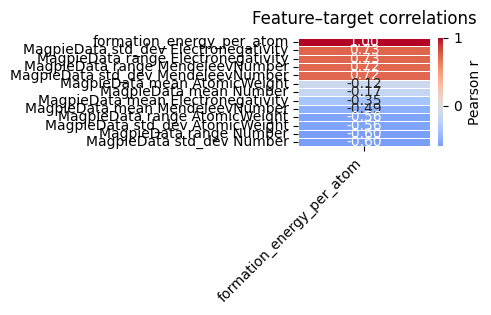

In [24]:

import seaborn as sns
import matplotlib.pyplot as plt

target = "formation_energy_per_atom"
corrs = df_feat.corr(numeric_only=True)[[target]].sort_values(by=target, ascending=False)

plt.figure(figsize=(5, len(corrs) * 0.25))  # scale height to number of features
ax = sns.heatmap(
    corrs,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Pearson r"},
    linewidths=0.5,
    linecolor="white"
)

# Fix ticklabel alignment
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.title("Feature–target correlations", pad=10)
plt.tight_layout()
plt.show()

---

### 🧩 Learning Exercise: Interpreting Feature–Target Correlations

Take a look at your correlation heatmap above.  

**Questions:**
1. Do *all* Magpie features show a strong correlation with the target (`formation_energy_per_atom`)?  
2. If some features have correlations close to zero, what might that mean?  
3. Can you explain *why* certain features (e.g. `MagpieData maximum N SValence`) show no apparent relationship to the target?

**Hints to explore:**
- 🧮 **Check for constant features:**  
  Some descriptors may have the same value for every compound in this small dataset — meaning no variance, so correlation is undefined or zero.  
  ```python
  df_feat.nunique().sort_values().head(10)


In [25]:
df_feat.nunique().sort_values().head(10)

,0
MagpieData range Number,2
MagpieData range MendeleevNumber,3
MagpieData range AtomicWeight,3
MagpieData range Electronegativity,3
MagpieData std_dev Number,4
MagpieData std_dev MendeleevNumber,4
MagpieData std_dev Electronegativity,5
MagpieData std_dev AtomicWeight,6
MagpieData mean Number,22
MagpieData mean MendeleevNumber,22



## 3) Train a simple Random Forest regressor

We'll predict **formation_energy_per_atom** from Magpie features.  
We use a modest number of trees to keep this lightweight for a worked example.


In [26]:

target_col = "formation_energy_per_atom"

# Define X, y
feature_cols = [c for c in df_feat.columns if c not in ["material_id", "formula_pretty", target_col]]
X = df_feat[feature_cols].values
y = df_feat[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)
print(f"Test MAE:  {mae:.3f} eV/atom")
print(f"Test RMSE: {rmse:.3f} eV/atom")
print(f"Test R²:   {r2:.3f}")


Test MAE:  0.289 eV/atom
Test RMSE: 0.466 eV/atom
Test R²:   0.683


## Plot the results

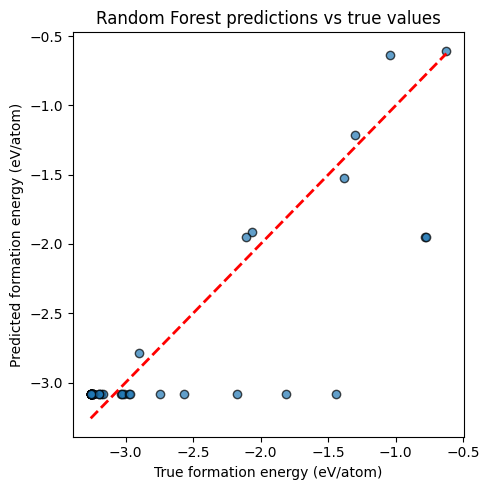

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", lw=2)

plt.xlabel("True formation energy (eV/atom)")
plt.ylabel("Predicted formation energy (eV/atom)")
plt.title("Random Forest predictions vs true values")
plt.tight_layout()
plt.show()


### Feature importances

### 🌳 Understanding Feature Importance

The **feature importance** values shown above tell us how much each input feature contributed to the model’s predictive performance.

In a **Random Forest**, importance is computed by averaging how much each feature reduces the model’s prediction error (or “impurity”) across all the trees.  
Features with higher importance values tend to have greater influence on the model’s decisions.

🧠 **But remember:**  
- Feature importance reflects the *model’s internal use* of features — not necessarily their true *physical causation*.  
- Highly correlated features can “share” importance, making interpretation tricky.  
- This method captures *non-linear* relationships that correlation alone cannot.

In [11]:

import numpy as np
import pandas as pd

importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
top20 = importances.head(20)
top20.to_frame("importance")


,importance
MagpieData avg_dev Row,0.135256
MagpieData avg_dev NUnfilled,0.132814
MagpieData mean MeltingT,0.129339
MagpieData mean NpUnfilled,0.120437
MagpieData avg_dev MeltingT,0.110032
MagpieData avg_dev GSvolume_pa,0.103491
MagpieData mean NUnfilled,0.102900
MagpieData mean GSvolume_pa,0.018474
MagpieData mean Electronegativity,0.017605
MagpieData mean SpaceGroupNumber,0.016658


### 🧩 Optional Exercise: Comparing Correlation and Model Importance

You’ve now seen two different ways to assess which features matter:

- **Correlation** — a simple *linear* relationship between each feature and the target.  
- **Model importance** — how much a feature actually helps the **Random Forest** predict correctly (which can include *nonlinear* and *interaction* effects).

**Your task:**  
1. Identify the top 10 most *correlated* features with the target (`formation_energy_per_atom`).  
2. Identify the top 10 *most important* features according to the Random Forest.  
3. Compare the two lists:
   - Which features appear in both?
   - Which ones differ — and why might that be?

**Hints:**
```python
# Top 10 by correlation (absolute Pearson r)
corrs = df_feat.corr(numeric_only=True)["formation_energy_per_atom"].abs().sort_values(ascending=False)
print(corrs.head(10))

# Top 10 by Random Forest importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances.head(10))


### 🚀 Stretch Exercise: Exploring Other Magpie and Oxidation-State Features

The **Magpie** preset (`ElementProperty.from_preset("magpie")`) provides a large set of *elemental-property* statistics — things like electronegativity, atomic weight, or valence electron counts, summarized by mean, max, range, and standard deviation across each composition.

But **matminer** includes many other descriptor types that capture *different kinds of chemistry*.  
Let’s explore a few directions you could take:

**1️⃣ Try different Magpie presets**

Other presets available are:
“deml”, “matminer”, “matscholar_el”, or “megnet_el”.

**2️⃣ Build your own custom featurizer**

You can explicitly choose which elemental properties and summary statistics to include:
```python
featurizer = ElementProperty(
    data_source="magpie",
    features=["Number", "MendeleevNumber", "Electronegativity", "AtomicWeight"],
    stats=["mean", "range", "std_dev"]
)
```

**3️⃣ 🔍 Explore oxidation-state-based features**

Some physical properties depend on oxidation state, not just elemental identity.
matminer includes featurizers that estimate oxidation states and build related descriptors, such as:
```python
from matminer.featurizers.composition import OxidationStates
OxidationStates().feature_labels()
```
You can also look at:

`ValenceOrbital` – fraction of electrons in s, p, d, f orbitals

`IonProperty` – ionic radius, ionization energies, etc.

**Note** to use these oxidation states features you need to know the oxidation states of the atoms, which we don't currently have. It is a bit beyond the scope of this course to address that now.


### (Optional) Save artifacts

You can uncomment the cells below to save the feature matrix and the trained model for reuse.


In [ ]:

# %pip install -q joblib
# import joblib
# joblib.dump(rf, "rf_magpie_model.joblib")
# df_feat.to_csv("magpie_features_with_targets.csv", index=False)
# print("Saved: rf_magpie_model.joblib, magpie_features_with_targets.csv")
